This notebook contains the routines to produce the flatmaps that visualize the parameter predictions of CFpRF and DeepRF. 

Author: Jordy Thielen (jordy.thielen@donders.ru.nl)

In [1]:
import os
import h5py
import cortex
import numpy as np
import nibabel as nib
from nilearn.surface import load_surf_data
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc, rcParams
rcParams['font.sans-serif'] = "Arial"
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
rcParams['font.family'] = "sans-serif"
rcParams['pdf.fonttype'] = 42
fontsize = 14
rcParams.update(
    {'legend.fontsize': fontsize,
     'axes.labelsize': fontsize,
     'axes.titlesize': fontsize,
     'xtick.labelsize': fontsize,
     'ytick.labelsize': fontsize})


In [2]:
# The hcp_999999 subject should be under the following directory
# Note, if you add a new subject in this database, you'll need to "restart" pycortex
from cortex.options import config
# print(cortex.options.usercfg)
print(config.get('basic', 'filestore'))


/anaconda3/share/pycortex/db


In [3]:
root = "/Users/jordythielen/2420084.01"
subject = "126426"
models = ["cfprf", "resnet50_chan"]
rois = ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d"]
hcp_subject = 'hcp_999998'  # 'hcp_999999'


In [4]:
"""
This cell takes the predicted pRF parameters, reshapes them back into the original brain space using the Wang 2015 
atlas, projects them to a flattened surface and splits the left and right hemisphere. These rourines are needed 
to visualized the flatmaps.

Note, for this script to run, the wb_command HCP tools should be installed, and the PATH variable should be correct 
so the tools can be found. 
Install wb_command from https://www.humanconnectome.org/software/workbench-command
It should be installed under /Applications/workbench/
In ~/.bashrc add: export PATH=$PATH:/Applications/workbench/bin_macosx64
One might need to call: source ~/.bashrc
"""

# Compute an average time-series, just to extract header
cii_in = os.path.join(root, "sourcedata", subject, "MNINonLinear", "Results", "tfMRI_RETBAR1_7T_AP", "tfMRI_RETBAR1_7T_AP_Atlas_hp2000_clean.dtseries.nii")
cii_out = os.path.join(root, "sourcedata", subject, "MNINonLinear", "Results", "tfMRI_RETBAR1_7T_AP", "tfMRI_RETBAR1_7T_AP_Atlas_hp2000_clean.dscalar.nii")
os.system(f"wb_command -cifti-reduce {cii_in} MEAN {cii_out} -direction ROW")

# Read averaged time-series cifti to get header and such
cii = nib.load(os.path.join(root, "sourcedata", subject, "MNINonLinear", "Results", "tfMRI_RETBAR1_7T_AP", "tfMRI_RETBAR1_7T_AP_Atlas_hp2000_clean.dscalar.nii"))

# Read voxel labels from atlas
with h5py.File(os.path.join(root, "derivatives", "analyseprf", "atlas.mat"), "r") as fid:
    atlas = np.array(fid["wang2015"]).astype("int").flatten()
    labels = ["".join(chr(c[0]) for c in fid[ref[0]]) for ref in fid["wang2015labels"]]
labels_idx = [i for i, lab in enumerate(labels) if lab in rois]

# Make ROI mask
mask = np.full(atlas.size, False)
for lab in labels_idx:
    mask[atlas == lab] = True

for model in models:

    # Read results
    results = np.load(os.path.join(root, "derivatives", model, f"results_empirical_{subject}.npz"))
    s = results["y_train"][:, 1]
    x = results["y_train"][:, 2]
    y = results["y_train"][:, 3]

    # Compute angle and eccentricity (cartesian to polar) and project to full brain
    output = dict()
    output["eccen"] = np.full((1, mask.size), np.nan)
    output["eccen"][:, mask] = np.sqrt(x**2 + y**2)
    output["angle"] = np.full((1, mask.size), np.nan)
    output["angle"][:, mask] = (np.mod(np.arctan2(-y, x) - 0.5*np.pi, 2*np.pi) / np.pi * 180)
    output["size"] = np.full((1, mask.size), np.nan)
    output["size"][:, mask] = s

    # Save cifti images with results
    for out in output.keys():

        # Save cifti with results
        nib.save(nib.Cifti2Image(output[out], cii.header, cii.nifti_header, cii.extra, cii.file_map), 
            os.path.join(root, "derivatives", model, f"{out}_{subject}.nii"))

        # Split cifti image into left and right part
        cii_in = os.path.join(root, "derivatives", model, f"{out}_{subject}.nii")
        cii_out = os.path.join(root, "derivatives", model, f"{out}_{subject}")
        os.system(f"wb_command -cifti-separate {cii_in} COLUMN -volume-all {cii_out}_subvol.nii.gz -metric CORTEX_LEFT {cii_out}_L.func.gii -metric CORTEX_RIGHT {cii_out}_R.func.gii")
        

In [5]:
def plot_flatmap(subject, model, metric="angle", ax=None, cb=False, title=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    
    surface_l = load_surf_data(os.path.join(root, "derivatives", model, f"{metric}_{subject}_L.func.gii"))
    surface_r = load_surf_data(os.path.join(root, "derivatives", model, f"{metric}_{subject}_R.func.gii"))
    surface = np.hstack([surface_l, surface_r])
    
    if metric == "angle":
        vmin, vmax = 0, 360
        cmap = "Retinotopy_RYBCR"
    elif metric == "eccen":
        vmin, vmax = 0, 10
        cmap = "rainbow"
    else:
        vmin, vmax = 0, 10
        cmap = "rainbow"
        
    vertex = cortex.Vertex(surface, subject=hcp_subject, cmap=cmap)
    cortex.quickshow(vertex, fig=ax, height=512, with_colorbar=cb,
        with_labels=False, with_rois=True, with_borders=True, with_sulci=True,
        with_curvature=True, curvature_brightness=0.5, curvature_contrast=0.5, curvature_threshold=False)
    
    ax.set_xlim((0.2*ax.get_xlim()[0], 0.3*ax.get_xlim()[1]))
    ax.set_ylim((0.3*ax.get_ylim()[0], 0.6*ax.get_ylim()[1]))
    
    if title:
        if model == "cfprf":
            ax.set_title("$\\bf{CFpRF}$\n" + metric)
        else:
            ax.set_title("$\\bf{DeepRF}$\n" + metric)


** (org.inkscape.Inkscape:87122): WARNING **: 13:48:10.513: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87122): WARNING **: 13:48:10.513: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87122): WARNING **: 13:48:10.513: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87122): WARNING **: 13:48:10.513: attribute 'clip-path' given as CSS
Fontconfig warning: ignoring UTF-8: not a valid region tag
Background RRGGBBAA: ffffff00
Area 0:0:2511.29:1024 exported to 1256 x 512 pixels (48 dpi)
** (org.inkscape.Inkscape:87125): WARNING **: 13:48:11.644: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87125): WARNING **: 13:48:11.644: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87125): WARNING **: 13:48:11.644: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87125): WARNING **: 13:48:11.644: attribute 'clip-path' given as CSS
Fontconfig warning: ignoring UTF-8: not a valid region tag
Background RRGGBBAA: ffffff00
A

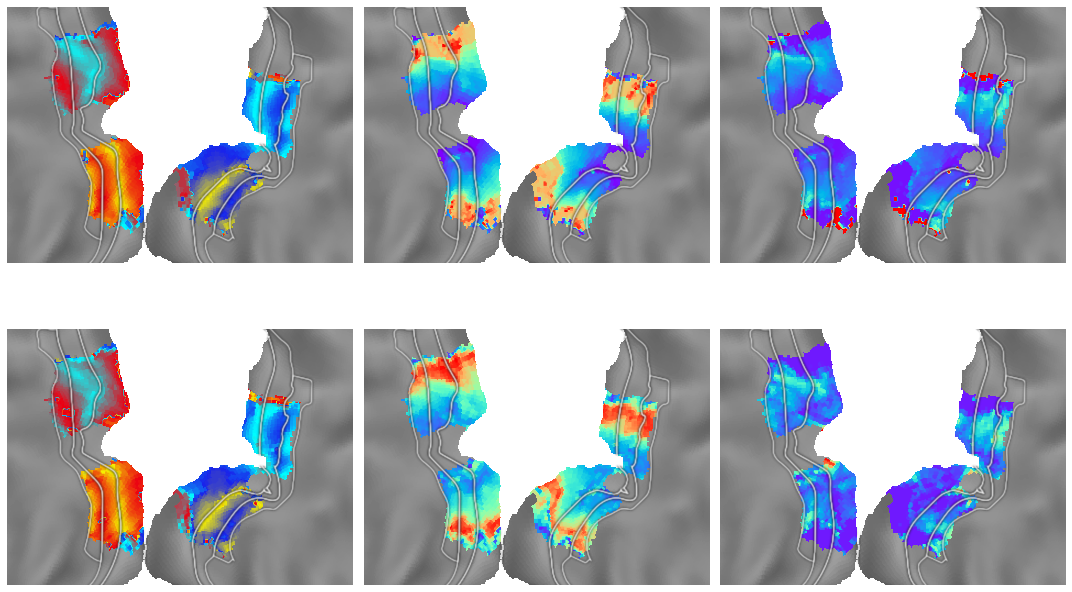

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))

plot_flatmap(subject, "cfprf", metric="angle", ax=axes[0,0])
plot_flatmap(subject, "cfprf", metric="eccen", ax=axes[0,1])
plot_flatmap(subject, "cfprf", metric="size", ax=axes[0,2])

plot_flatmap(subject, "resnet50_chan", metric="angle", ax=axes[1,0])
plot_flatmap(subject, "resnet50_chan", metric="eccen", ax=axes[1,1])
plot_flatmap(subject, "resnet50_chan", metric="size", ax=axes[1,2])

fig.tight_layout()
plt.savefig(os.path.join(root, "derivatives", "flatmaps.pdf"), dpi=150)


** (org.inkscape.Inkscape:87151): WARNING **: 13:48:29.025: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87151): WARNING **: 13:48:29.025: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87151): WARNING **: 13:48:29.025: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87151): WARNING **: 13:48:29.025: attribute 'clip-path' given as CSS
Fontconfig warning: ignoring UTF-8: not a valid region tag
Background RRGGBBAA: ffffff00
Area 0:0:2511.29:1024 exported to 1256 x 512 pixels (48 dpi)
** (org.inkscape.Inkscape:87152): WARNING **: 13:48:30.171: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87152): WARNING **: 13:48:30.171: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87152): WARNING **: 13:48:30.171: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87152): WARNING **: 13:48:30.171: attribute 'clip-path' given as CSS
Fontconfig warning: ignoring UTF-8: not a valid region tag
Background RRGGBBAA: ffffff00
A

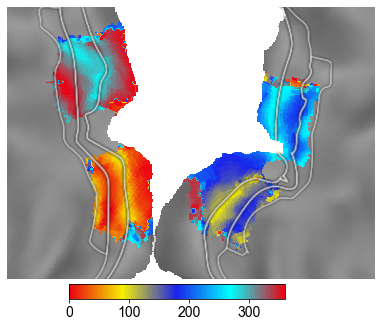

In [7]:
plot_flatmap(subject, "cfprf", metric="angle", cb=True)
plt.savefig(os.path.join(root, "derivatives", "flatmap_cfprf_angle.pdf"))


** (org.inkscape.Inkscape:87154): WARNING **: 13:48:31.931: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87154): WARNING **: 13:48:31.931: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87154): WARNING **: 13:48:31.931: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87154): WARNING **: 13:48:31.931: attribute 'clip-path' given as CSS
Fontconfig warning: ignoring UTF-8: not a valid region tag
Background RRGGBBAA: ffffff00
Area 0:0:2511.29:1024 exported to 1256 x 512 pixels (48 dpi)
** (org.inkscape.Inkscape:87155): WARNING **: 13:48:33.024: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87155): WARNING **: 13:48:33.024: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87155): WARNING **: 13:48:33.024: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87155): WARNING **: 13:48:33.024: attribute 'clip-path' given as CSS
Fontconfig warning: ignoring UTF-8: not a valid region tag
Background RRGGBBAA: ffffff00
A

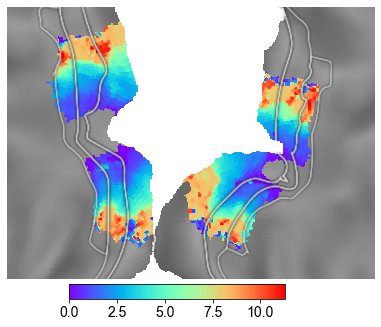

In [8]:
plot_flatmap(subject, "cfprf", metric="eccen", cb=True)
plt.savefig(os.path.join(root, "derivatives", "flatmap_cfprf_eccen.pdf"))


** (org.inkscape.Inkscape:87157): WARNING **: 13:48:34.784: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87157): WARNING **: 13:48:34.784: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87157): WARNING **: 13:48:34.784: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87157): WARNING **: 13:48:34.784: attribute 'clip-path' given as CSS
Fontconfig warning: ignoring UTF-8: not a valid region tag
Background RRGGBBAA: ffffff00
Area 0:0:2511.29:1024 exported to 1256 x 512 pixels (48 dpi)
** (org.inkscape.Inkscape:87158): WARNING **: 13:48:35.946: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87158): WARNING **: 13:48:35.946: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87158): WARNING **: 13:48:35.946: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:87158): WARNING **: 13:48:35.946: attribute 'clip-path' given as CSS
Fontconfig warning: ignoring UTF-8: not a valid region tag
Background RRGGBBAA: ffffff00
A

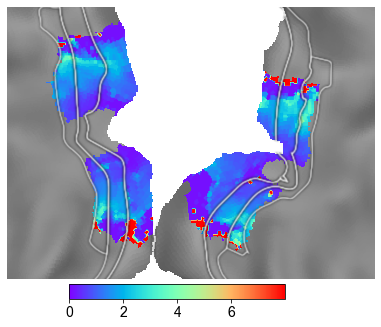

In [9]:
plot_flatmap(subject, "cfprf", metric="size", cb=True)
plt.savefig(os.path.join(root, "derivatives", "flatmap_cfprf_size.pdf"))
